# Final Project for Data Mining Course, Data Science and Application 
## Metro College of Technology

### September, 2021

### Ana Clara Tupinambá Freitas, oriented by Professor Gitimoni Saikia

# Car evaluation

## Introduction

Can we predict the acceptability of a car? 

The features for this study are:

    *Class Values:

        - unacceptable, 
        - Acceptable
        - Good
        - Very good
    *Buying: 
        - Very high
        - High
        - Medium
        - Low
    *Maintenance:
        - Very high
        - High
        - Medium
        - Low
    *Doors:
        - 2
        - 3 
        - 4 
        - 5more.
    *Persons: 
         - 2
         - 4
         - more
    *Lug_boot: 
         - small
         - medium
         - big
    *Safety:
         - low
         - medium
         - high

The **target** feature in this study will be: **Class**.

Data Source: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation, downloaded at Sep 9th,2021

# Importing Packages

In [1]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import kstest
import researchpy as rp
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats.contingency import chi2_contingency


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.utils import shuffle

import warnings


# User Defined Functions

## Univariate Categorical:

In [2]:
def uni_categorical(df,size):
    '''This function returns summarization and visual for univariate analysis of categorical features of a dataset'''
    print('############### Univariate analysis - Categorical ###############')
    df = df.select_dtypes(exclude=np.number) #extracting only non-numerical features
    for i in df.columns:
     #   if type(df.loc[0, i]) == str: #checking type of features
# Summarization
            d1 = df[i].value_counts()
            d2 = round(df[i].value_counts(normalize=True)*100, 2)
            d3 = pd.concat([d1, d2], axis=1)
            d3.columns = ['Count', 'Percentage']
            print('\nThis is univariate analysis for', "'", i, "'", '\n', d3)

 # Visualization
            d1 = pd.DataFrame(d1).T
            d1 = pd.melt(d1,var_name=str(i),value_vars=d1) 
            fig, ax = plt.subplots()
            if size == 'L':
                fig.set_size_inches(12, 10)
            else:
                fig.set_size_inches(5, 5)
            sns.set_context("paper", font_scale=1.5)
            plot1=sns.barplot(y=d1['value'],x=d1[i], data=d1)
            for p, label in zip(plot1.patches, d1['value']):
                ax.annotate(label, (p.get_x()+0.3, p.get_height()+2))
            plt.xticks(rotation=45, ha='right')
            ax.set_title('Univariate plot')
            plt.show()
    print('\n\n')

## Univariate Numerical:

In [3]:
def uni_numerical(df):
    '''This function returns summarization and visual for univariate analysis of numerical features of a dataset'''
    
# Summarization
    print('############### Univariate analysis - Numerical ###############')
    df.describe()

    Summary = dict(df.describe())
    for i in Summary:
        Summary[i]['count'] = df[i].count()
        Summary[i]['variance'] = df[i].var()
        Summary[i]['IQR'] = Summary[i]['75%'] - Summary[i]['25%']
        Summary[i]['range'] = Summary[i]['max'] - Summary[i]['min']
        Summary[i]['skewness'] = df[i].skew()
        Summary[i]['kurtosis'] = df[i].kurtosis()
        Summary[i]['mode'] = df[i].mode() #axis='columns'
#    print(Summary)
        print('\nThis is univariate analysis for',"'", i, "'", '\n', Summary[i])
# Visualization
        # Histogram and Boxplot
        sns.set_palette("dark") # colorblind   pastel
        sns.set(style="white") #whitegrid ticks
        sns.set_context("paper", font_scale=1.5)
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.12, .88)})
        f.set_size_inches(12, 8)
        sns.distplot(a=df[i], hist=True, kde=True, rug=True, ax=ax_hist)
        sns.boxplot(x=df[i], ax=ax_box)
        ax_box.set_title('Univariate plot')
        ax_box.set(xlabel='')
        plt.show()
# normality test
#        stat, p_normal = shapiro(df[i])
        stat, p_normal = kstest(df[i],'norm')    
        print('Kolmogorov\'s Statistics=%.3f, p=%.3f' % (stat, p_normal))
# interpretation
        alpha = 0.05
        if p_normal > alpha:
            print('Normality\'s test result: Sample looks Gaussian (fail to reject H0)')
        else:
            print('Normality\'s test result: Sample does not look Gaussian (reject H0)')

## Bivariate Numerical target x Numerical features:

In [4]:
def bi_numerical_num(df, var_target):
    '''This function returns summarization, visual,and test of independency for bivariate analysis of numerical x numerical features. FIgFigure size: 'S' or 'L' '''
    
    print('############### Bivariate analysis - Numerical x Numerical ###############')
# Printing Assumptions:
    print('\nCorrelation (how strong the correlation is):\n Null hypothesis: there’s no association between variables.\n\n Assumptions:\n \t1.Normal distribution for both variables for pearson;\n  \t2.homoscedasticity assumes that data is equally distributed about the regression line.\n \t3.Linear? \n \t\tLinear: pearson\n \t\tMonotonically related (not normal) use the following methods: spearman kendall hoeffding \n Generical interpretation: \n \t |0.7| < p -> strong correlation \n \t |0.7| > p > |0.5| -> moderately correlated \n \t |0.4| > p -> weakly correlated or no correlation ')

# Verifying datatypes extract only numerics
    df = df.select_dtypes(include=np.number)
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# Visualization
    sns.set_palette("dark") # colorblind   pastel
    sns.set(style="white",font_scale=1) #whitegrid ticks
    
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(8,8)) 
    sns.heatmap(round(df.corr(method='pearson'),2),annot=True, annot_kws={"fontsize":12},square=True, linewidths=0.01,mask=mask,ax=ax)
    plt.title('Correlation Heatmap - Pearson')   
    plt.show()
    
   # mask = np.zeros_like(df.corr())
   # mask[np.triu_indices_from(mask)] = True
    #fig, ax = plt.subplots(figsize=(8,8))
    #sns.heatmap(round(df.corr(method='spearman'),2),annot=True, annot_kws={"fontsize":12},square=True, linewidths=0.01,mask=mask,ax=ax)
    #plt.title('Correlation Heatmap - Spearman') 
    #plt.show()

## Bivariate Numerical target x Categorical features:

In [5]:

def bi_categorical_cont(df,var_target,size):                
    '''This function returns summarization, visual, and test of independency for bivariate analysis of continuous target x categorical  features,taking a continuous variable as the target.  '''
    
    print('############### Bivariate analysis - Categorical x Numerical ###############')
    print('\n*If Categorical has 2 levels: Mann-Whitney U test, if more: One-way ANOVA/Kruskal H test')

# Defining alpha:
    alpha = 0.05
# Verifying datatypes extract only numerics
    df_num = df.select_dtypes(include=np.number) 
    
# If target is numeric:         
    if var_target in df_num.columns:
        df_cat = df.select_dtypes(exclude=np.number)
        for i in df_cat.columns:
            if i != var_target:
                vis = pd.crosstab(df[var_target],df[i], margins = False)
                tab = rp.summary_cont(df[var_target].groupby(df[i]),decimals=3)#conf=0.95
#                print(tab)
                result = df.groupby(i)[var_target].apply(list) 
#                print('Result:',result)
# Printing Assumptions:
                if len(result.index) == 2:
                    print('\nThis is Mann-Whitney U test for' , var_target, 'and',i )
                    print('\nMann-Whitney U test:\n Null hypothesis: The distribution of scores for the two groups are equal.\n Assumptions:\n 1.Dependent variable that is measured at the continuous or ordinal level.\n 2.Groups are independent of one another. \n 3.What\'s the shape of each group distribution.\n\t a) Similar shapes: \n\t\t Alternative hypothesis: the medians of the two groups are not equal.\n\t b) Different shapes:\n\t\t Alternative hypothesis: the distribution of scores for the two groups are not equal.') 
                    print('\nSummary:')
                    print(tab)
# Visualization
                    sns.set_palette("dark") # colorblind   pastel
                    sns.set(style="white") # whitegrid ticks
                    fig, ax = plt.subplots()
                    fig.set_size_inches(12, 4)
                    sns.boxplot(x=df[i],y=df[var_target], data=df)  
                    sns.stripplot(x=df[i],y=df[var_target], data=df,
              size=4, color=".3", linewidth=0)
                    plt.xticks(rotation=45, ha='right')
                    ax.set_title('Bivariate plot: ' + var_target + ' and ' + i)
                    plt.show()
                    l = pd.melt(vis,var_name=str(i),value_vars=vis)
                    l = pd.DataFrame(l)
                
                else:
# ANOVA
# Printing Assumptions: 
                    print('\nThis is ANOVA/Kruskal for' , var_target, 'and',i,'\n' )
                    print('One-way ANOVA Assumptions\n In order to run a one-way ANOVA the following assumptions must be met:\n 1.The response of interest is continuous and normally distributed for each treatment group.\n \tCLT :\n \t\tIf looks normal each group must have more than 30 observations – no need for Normality’s test;\n \t\tIf moderately skewed(|0.5| < skewness < |1.0|), each group must have more than 100 observations – no need for Normality’s test;\n\t*If not normal, proceed to Kruskal test.\n 2.Treatment groups are independent of one another. \n 3.There are no major outliers.\n 4.A check for unequal variances will help determine which version of a one-way ANOVA is most appropriate (Levene’s test, Null hypothesis: variances are equal between groups):\n \tA .If variances are equal, then the assumptions of a standard one-way ANOVA are met.\n \tB. If variances are unequal, then a Kruskal’s test is appropriate.\n\n*Kruskal\'s Null hypothesis: H0: the group populations have equal dominance; i.e. when one element is drawn at random from each group population, the largest (or smallest, or second smallest, etc.) element is equally likely to come from any one of the group populations or H0: the group population medians are equal(if groups distributions have the same shape) ')
                    print('\nSummary:')
                    print(tab)
# Visualization
                    sns.set_palette("dark") # colorblind   pastel
                    sns.set(style="white") # whitegrid ticks
                    fig, ax = plt.subplots()
                    if size == 'L':
                        fig.set_size_inches(50, 4)
                    else:
                        fig.set_size_inches(12, 4)
                    sns.set_context("paper", font_scale=1.2)
                    sns.boxplot(x=df[i],y=df[var_target], data=df)  
                    sns.stripplot(x=df[i],y=df[var_target], data=df,
              size=4, color=".3", linewidth=0)
                    plt.xticks(rotation=45, ha='right',fontsize=12)
                    ax.set_title('Bivariate plot: ' + var_target + ' and ' + i)
                    plt.show()
                    l = pd.melt(vis,var_name=str(i),value_vars=vis)
                    l = pd.DataFrame(l)
                    
            if len(result.index) == 2:
#T-test                             
                stat_l, p_lev = levene(*result)
                print('\nLevene\'s Statistics=%.3f, p=%.3f' % (stat_l, p_lev))
                if p_lev  > alpha:#Equal varinaces
                    stat_u, p_u = mannwhitneyu(*result)
                    print('Levene\'s test result: Equal variances (fail to reject H0)')
                    print('\nMann-Whitney U \'s Null hypothesis: The distribution of scores for the two groups are equal.')
                    print('\nMann-Whitney U \'s Statistics (equal variances)=%.3f, p=%.3f' % (stat_u, p_u))
# interpretation
                    if p_u > alpha: 
                        print('Mann-Whitney U \'s test result: There are no differences in medians, samples medians are equal. (fail to reject H0)')
                    else:
                        print('Mann-Whitney U \'s test result: The medians of the two groups are not equal. (reject H0)')  
                        
                else:#Unequal variances
                    stat_u, p_u = mannwhitneyu(*result)
                    print('Levene\'s test result: Unequal variances (reject H0)')
                    print('\nMann-Whitney U \'s Statistics (unequal variances)=%.3f, p=%.3f' % (stat_u, p_u))
# interpretation
                    if p_u > alpha: 
                        print('\nMann-Whitney U \'s Null hypothesis: The distribution of scores for the two groups are equal.')
                        print('Mann-Whitney U \'s test result: The distribution of scores for the two groups are equal. (fail to reject H0)')
                    else:
                        print('\nMann-Whitney U \'s Null hypothesis: The distribution of scores for the two groups are equal.')
                        print('Mann-Whitney U \'s test result: The distribution of scores for the two groups are not equal. (reject H0)')   
                    
  
# ANOVA
            else:    
                stat_l, p_lev = levene(*result)
                print('\nLevene\'s Statistics=%.3f, p=%.3f' % (stat_l, p_lev))
                p_one = np.nan
                if p_lev  > alpha: #Equal variances
                    stat_one, p_one = f_oneway(*result)
                    stat_k, p_h =  kruskal(*result)
                    print('Levene\'s test result: equal variances (reject H0)')
                    print('\nKruskal\'s Statistics(equal variances)=%.3f, p=%.3f' % (stat_k, p_h))
                    print('\nANOVA\'s Statistics(equal variances)=%.3f, p=%.3f' % (stat_one, p_one))
                    if p_one > alpha: 
                        print('\nANOVA\'s Null hypothesis: There are  differences in means')
                        print('ANOVA\'s test result: There are no differences in means, samples are equal. (fail to reject H0)')
                    else:
                        print('\nANOVA\'s Null hypothesis: There are  differences in means')
                        print('ANOVA\'s test result: There are  differences in means (reject H0)')   
                else: # Unequal variances
                    stat_k, p_h  = kruskal(*result)
                    print('Levene\'s test result: Unequal variances (reject H0)')
                    print('\nKruskal\'s Statistics(unequal variances)=%.3f, p=%.3f' % (stat_k, p_h))
                
                if p_h > alpha: 
                    print('\nKruskal\'s Null hypothesis: All sample distributions are equal.')
                    print('Kruskal\'s test result: All sample distributions are equal. (fail to reject H0)')
                else:
                    print('\nKruskal\'s Null hypothesis: All sample distributions are equal.')
                    print('Kruskal\'s test result: One or more sample distributions are not equal. (reject H0)')   

    print('\n\n')

## Bivariate Numerical target x Categorical features:

In [6]:
def bi_categorical_cat(df_var_pred, df_var_target):
    '''This function returns summarization, visual,and test of independency for bivariate analysis of categorical x categorical features. df[var_pred], df[var_target]'''
    
    contigency_table = pd.crosstab(df_var_pred,df_var_target)
    print('This is contingency table for:\n\n',contigency_table,'\n')

    contigency_table.plot(kind='bar',figsize=(10,5))
#     plt.legend(loc=5)
    plt.show()
    alpha = 0.05
    chi_2, p_val, dof, exp_val = chi2_contingency(contigency_table)
    print("Chi-sqare's results:\n")
    if p_val > alpha:
        print('DOF: ',dof,'\np-value= ',p_val,"\n\n Fail to reject Null Hypothesis. There's no correlation between variables.")
    else:
        print('DOF: ',dof,'\np-value= ',p_val,"\n\n Reject Null Hypothesis. There's some correlation between variables.")   

In [7]:
## Calculating Adjusted R^2 value

In [8]:
def adjR2(X,R2):
    '''This function returns the R^2 value given X and R^2 value'''
    n = X.shape[0]
    k = X.shape[1]
    return 1 - ((n-1)/(n-k-1))*(1-R2)

## Plot of the model coefficients with 95% interval

In [9]:
# Define function to output plot of the model coefficients with 95% interval

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(35, 3))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

## Add Seasons

In [10]:
def find_season(month):
    season_month_north = {
        12:'Winter', 1:'Winter', 2:'Winter',
        3:'Spring', 4:'Spring', 5:'Spring',
        6:'Summer', 7:'Summer', 8:'Summer',
        9:'Autumn', 10:'Autumn', 11:'Autumn'}
    return season_month_north.get(month)

## Checking Missing values

In [11]:
def chck_miss(df):

    Total = df.isnull().count().sort_values(ascending=True)        
    Missing = df.isnull().sum().sort_values(ascending=True)   

    Percentage_Miss = round((Missing/Total)*100,2)

    Summary = pd.concat([Total,Missing, Percentage_Miss],axis=1,keys=['Total','# Missing','% Missing'],sort=True)
          
    print('Are there any missing value?')                    
    print(Summary)         

    del Total, Missing, Percentage_Miss, Summary 

#### Setting warnings OFF

In [12]:
#warnings.filterwarnings('ignore')

# Loading Data Frame

In [13]:
# Changing Directory
os.chdir(r'D:\1_Metro College\Courses\Data Mining\FInal_Project_Log_Reg')

df = pd.read_csv('Data\car.data',header=None)

df.rename(columns={0:'buying',
                    1:'maint',
                    2:'doors',
                    3:'persons',
                    4:'lug_boot',
                    5:'safety',
                    6:'class'},inplace=True)

## First look at the dataset:
We see that there are 7 features and 1728 observations in the dataset in it's downloaded form:

In [14]:
df.shape

(1728, 7)

First and Last observations:

In [15]:
df

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


#### What are the different data types of the dataframe?

We see that all features are categorical.

In [16]:
print('Features types:\n ',df.dtypes) 

Features types:
  buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object


# Verifying and, if existent, Handling of Duplicates and Missing Values

#### Is there duplicates?

We can see that there no duplicated values.

In [17]:
print('There are', df.duplicated().sum(), 'duplicated values' )
df.drop_duplicates(keep='last',inplace=True)

There are 0 duplicated values


#### Checking for missing values:

In [18]:
chck_miss(df)

Are there any missing value?
          Total  # Missing  % Missing
buying     1728          0        0.0
class      1728          0        0.0
doors      1728          0        0.0
lug_boot   1728          0        0.0
maint      1728          0        0.0
persons    1728          0        0.0
safety     1728          0        0.0


We see that there are no missing values.

Setting categorical features as such:

In [19]:
for i in df.columns:
    df[i] = df[i].astype('category')

#### Checking Summary of all features of the dataset:

In [20]:
df.describe(include='all').T

,count,unique,top,freq
buying,1728,4,high,432
maint,1728,4,high,432
doors,1728,4,2,432
persons,1728,3,2,576
lug_boot,1728,3,big,576
safety,1728,3,high,576
class,1728,4,unacc,1210


### Univariate Analysis

#### Looking at categorical features:

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' buying ' 
        Count  Percentage
high     432        25.0
low      432        25.0
med      432        25.0
vhigh    432        25.0


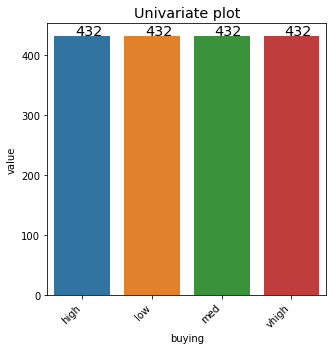

In [21]:
uni_categorical(df[['buying']],'S')

We see that buyng is equally distributed between the observations.

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' maint ' 
        Count  Percentage
high     432        25.0
low      432        25.0
med      432        25.0
vhigh    432        25.0


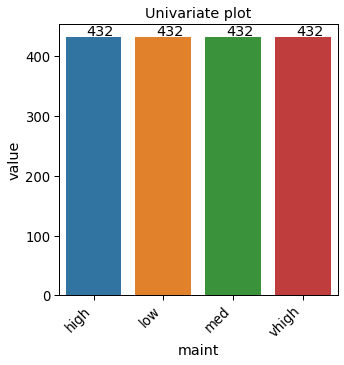

In [22]:
uni_categorical(df[['maint']],'S')

It's the same with maintenance feature: they are equally distributed.

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' doors ' 
        Count  Percentage
2        432        25.0
3        432        25.0
4        432        25.0
5more    432        25.0


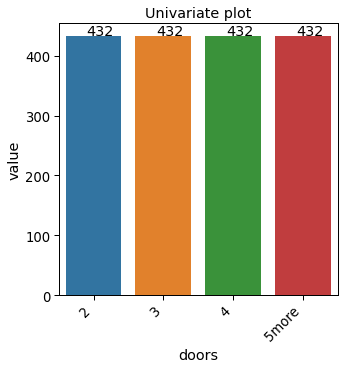

In [23]:
uni_categorical(df[['doors']],'S')

It's the same with doors feature: they are equally distributed.

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' persons ' 
       Count  Percentage
2       576       33.33
4       576       33.33
more    576       33.33


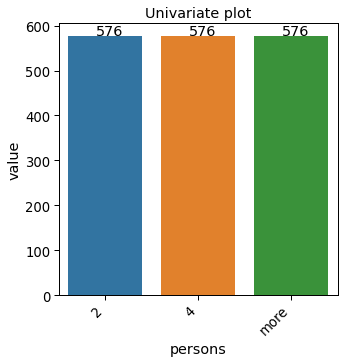

In [24]:
uni_categorical(df[['persons']],'S')

It's the same with persons feature: they are equally distributed.

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' lug_boot ' 
        Count  Percentage
big      576       33.33
med      576       33.33
small    576       33.33


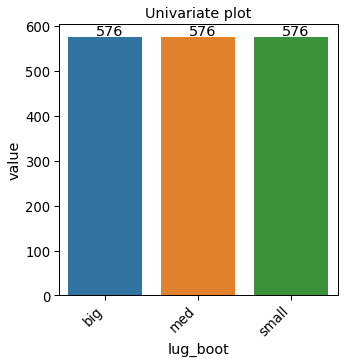

In [25]:
uni_categorical(df[['lug_boot']],'S')

It's the same with luggage boot feature: they are equally distributed.

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' safety ' 
       Count  Percentage
high    576       33.33
low     576       33.33
med     576       33.33


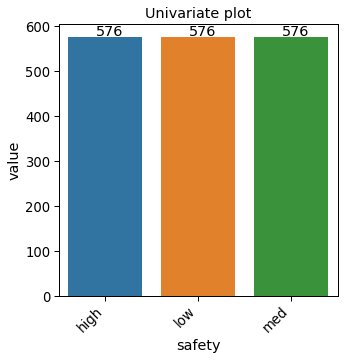

In [26]:
uni_categorical(df[['safety']],'S')

It's the same with safety feature: they are equally distributed.

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' class ' 
        Count  Percentage
unacc   1210       70.02
acc      384       22.22
good      69        3.99
vgood     65        3.76


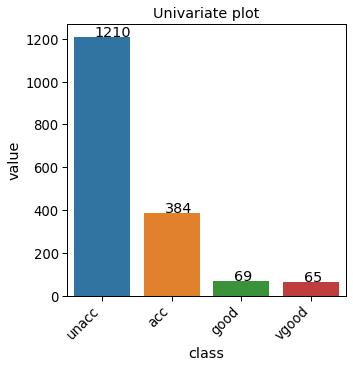

In [27]:
uni_categorical(df[['class']],'S')

We can see that our target in unbalanced. This will not be addressed within the scope of this study.

In [28]:
### Bivariate Analysis

#### Looking at categorical features:

This is contingency table for:

 class   acc  good  unacc  vgood
buying                         
high    108     0    324      0
low      89    46    258     39
med     115    23    268     26
vhigh    72     0    360      0 



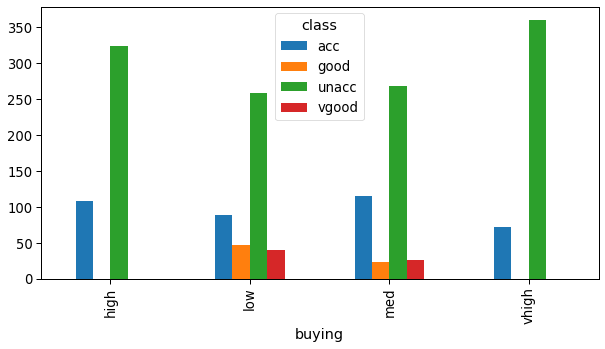

Chi-sqare's results:

DOF:  9 
p-value=  5.9280625992133936e-36 

 Reject Null Hypothesis. There's some correlation between variables.


In [29]:
bi_categorical_cat(df['buying'], df['class'])

This is contingency table for:

 class  acc  good  unacc  vgood
maint                         
high   105     0    314     13
low     92    46    268     26
med    115    23    268     26
vhigh   72     0    360      0 



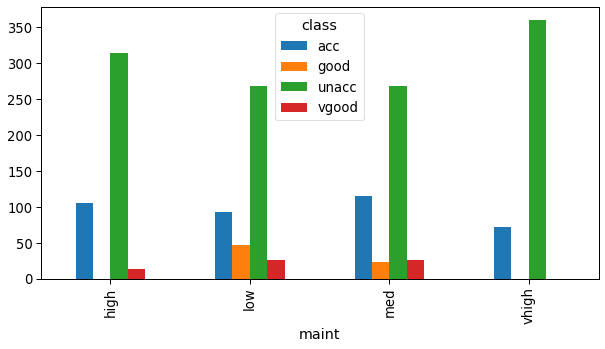

Chi-sqare's results:

DOF:  9 
p-value=  2.5476519845077733e-26 

 Reject Null Hypothesis. There's some correlation between variables.


In [30]:
bi_categorical_cat(df['maint'], df['class'])

This is contingency table for:

 class  acc  good  unacc  vgood
doors                         
2       81    15    326     10
3       99    18    300     15
4      102    18    292     20
5more  102    18    292     20 



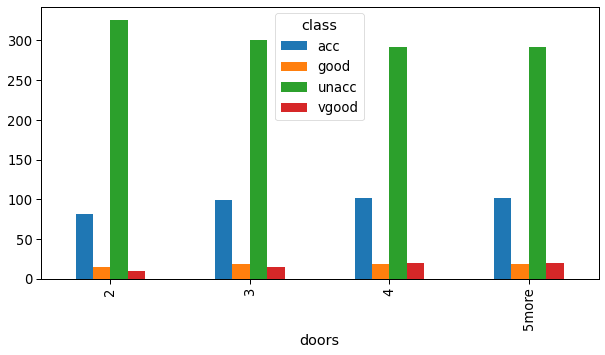

Chi-sqare's results:

DOF:  9 
p-value=  0.32024215990030563 

 Fail to reject Null Hypothesis. There's no correlation between variables.


In [31]:
bi_categorical_cat(df['doors'], df['class'])

This is contingency table for:

 class    acc  good  unacc  vgood
persons                         
2          0     0    576      0
4        198    36    312     30
more     186    33    322     35 



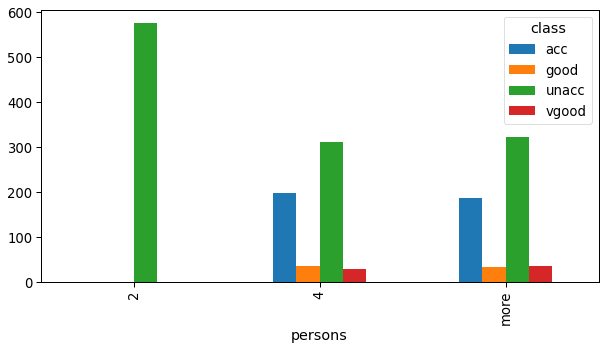

Chi-sqare's results:

DOF:  6 
p-value=  4.039968047270742e-77 

 Reject Null Hypothesis. There's some correlation between variables.


In [32]:
bi_categorical_cat(df['persons'], df['class'])

This is contingency table for:

 class     acc  good  unacc  vgood
lug_boot                         
big       144    24    368     40
med       135    24    392     25
small     105    21    450      0 



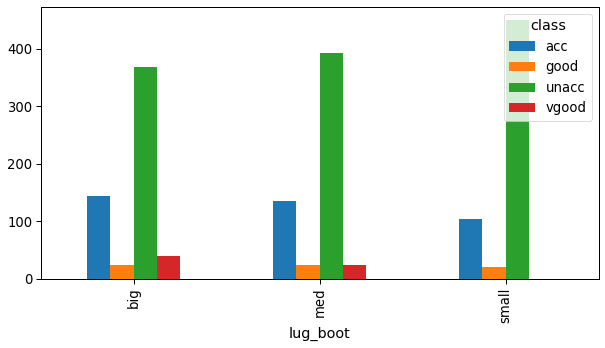

Chi-sqare's results:

DOF:  6 
p-value=  1.0294402753134833e-09 

 Reject Null Hypothesis. There's some correlation between variables.


In [33]:
bi_categorical_cat(df['lug_boot'], df['class'])

This is contingency table for:

 class   acc  good  unacc  vgood
safety                         
high    204    30    277     65
low       0     0    576      0
med     180    39    357      0 



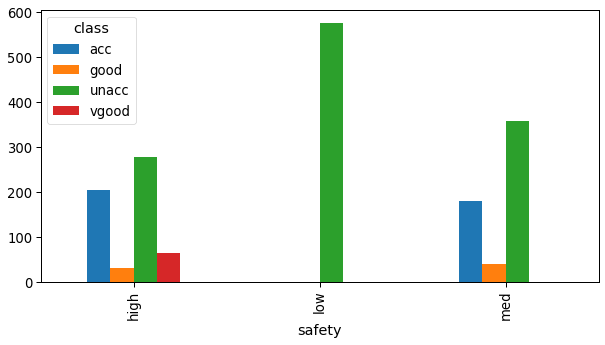

Chi-sqare's results:

DOF:  6 
p-value=  2.389155399044034e-100 

 Reject Null Hypothesis. There's some correlation between variables.


In [34]:
bi_categorical_cat(df['safety'], df['class'])

This is contingency table for:

 class    acc  good  unacc  vgood
persons                         
2          0     0    576      0
4        198    36    312     30
more     186    33    322     35 



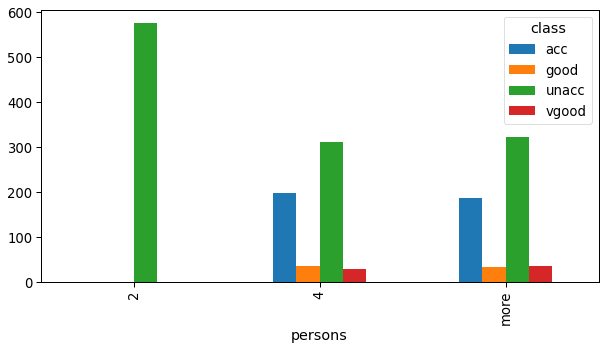

Chi-sqare's results:

DOF:  6 
p-value=  4.039968047270742e-77 

 Reject Null Hypothesis. There's some correlation between variables.


In [35]:
bi_categorical_cat(df['persons'], df['class'])

#### Extracting independent and dependent vars:

In [36]:
target='class'

# Creating copy of df1:
df_dummy = df.copy()

#Dummy variable encoding for all other categorical features: 
cols = ['buying', 'maint', 'persons', 'doors', 'lug_boot', 'safety'] 
df_dummy = pd.get_dummies(df_dummy,columns=cols,drop_first=True).reset_index(drop = True)

X = df_dummy.drop([target],axis=1)
y = df_dummy[target]

#### Spliting to train and test datasets:

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.3)

#### Scaling the features using training set:

In [38]:
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train),columns=X.columns)
X_test_scaled = pd.DataFrame(sc.transform(X_test),columns=X.columns)
X_full = pd.DataFrame(sc.transform(X),columns=X.columns)

### Training the model(tol=0.5, without weights):

In [39]:
#We use saga solver for large dataset 
#and class_weight to deal with the imbalance
model = LogisticRegression(tol=0.5,solver='saga') #, class_weight={'unacc':5, 'acc':3,'vgood':1, 'good':1}
model.fit(X_train_scaled,y_train)#max_iter=500,

LogisticRegression(solver='saga', tol=0.5)

#### Validating the model:

##### Training accuracy

In [40]:
y_pred = model.predict(X_train_scaled)
accuracy_score(y_train,y_pred)

0.9164598842018197

##### Testing Accuracy

In [41]:
y_pred = model.predict(X_test_scaled)
accuracy_score(y_test,y_pred)

0.8631984585741811

The accuracy is good, even if not great, with both the trainning and testing dataset.

##### Confusion Matrix:

In [42]:
y_pred = model.predict(X_full)
print(confusion_matrix(y,y_pred))
# Acc Good Unacc VGood 

[[ 326   10   43    5]
 [  37   25    0    7]
 [  60    2 1147    1]
 [   6    1    0   58]]


We see above that most of the Unacceptable observations were rightly classified.

#####  Classification Report:

In [43]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

         acc       0.76      0.85      0.80       384
        good       0.66      0.36      0.47        69
       unacc       0.96      0.95      0.96      1210
       vgood       0.82      0.89      0.85        65

    accuracy                           0.90      1728
   macro avg       0.80      0.76      0.77      1728
weighted avg       0.90      0.90      0.90      1728



We see that the overall accuracy is good. As well the precision and recall of the most business-risk category: unacceptable.

### k-fold cross validation using logistic regression model(without weights):

In [44]:
scores = cross_val_score(model,X_full,y)
print('Cross validation score(default parameter - "cv=5") is:',scores.mean())

scores = pd.Series(scores)
print('Minimum validation score is:',scores.min())
print('Maximum validation score is:', scores.max())


Cross validation score(default parameter - "cv=5") is: 0.6810186814107397
Minimum validation score is: 0.5072463768115942
Maximum validation score is: 0.8179190751445087


### Training the model(tol=0.5, with weights for classes):

The weights were defined roughly based on the inverse distribution of the classes.

############### Univariate analysis - Categorical ###############

This is univariate analysis for ' class ' 
        Count  Percentage
unacc   1210       70.02
acc      384       22.22
good      69        3.99
vgood     65        3.76


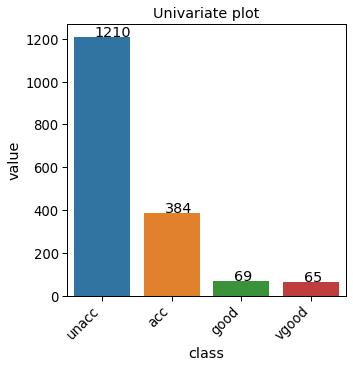

In [45]:
uni_categorical(df[['class']],'S')

In [46]:
#We use saga solver for large dataset 
#and class_weight to deal with the imbalance
model1 = LogisticRegression(tol=0.5,solver='saga', class_weight={'unacc':.6, 'acc':1.8,'vgood':3.8, 'good':3.8}) 
model1.fit(X_train_scaled,y_train)

LogisticRegression(class_weight={'acc': 1.8, 'good': 3.8, 'unacc': 0.6,
                                 'vgood': 3.8},
                   solver='saga', tol=0.5)

#### Validating the model:

In [47]:
##### Training accuracy

In [48]:
y_pred = model1.predict(X_train_scaled)
accuracy_score(y_train,y_pred)

0.8453267162944582

In [49]:
##### Testing Accuracy

In [50]:
y_pred = model1.predict(X_test_scaled)
accuracy_score(y_test,y_pred)

0.8053949903660886

The accuracy is good, even if not great, with both the trainning and testing dataset. But,there's loss compared to the undefined weight model.

##### Confusion Matrix:

In [51]:
y_pred = model1.predict(X_full)
print(confusion_matrix(y,y_pred))
# Acc Good Unacc VGood 

[[ 310   23   27   24]
 [  20   41    0    8]
 [ 150    9 1029   22]
 [   1    4    0   60]]


#####  Classification Report:

In [52]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

         acc       0.64      0.81      0.72       384
        good       0.53      0.59      0.56        69
       unacc       0.97      0.85      0.91      1210
       vgood       0.53      0.92      0.67        65

    accuracy                           0.83      1728
   macro avg       0.67      0.79      0.71      1728
weighted avg       0.87      0.83      0.84      1728



### k-fold cross validation using logistic regression model1(with weights):

In [53]:
scores = cross_val_score(model1,X_full,y)
print('Cross validation score(default parameter - "cv=5") is:',scores.mean())

scores = pd.Series(scores)
print('Minimum validation score is:',scores.min())
print('Maximum validation score is:', scores.max())

Cross validation score(default parameter - "cv=5") is: 0.6392778755131105
Minimum validation score is: 0.47246376811594204
Maximum validation score is: 0.7861271676300579


There's a loss in overall measures with the weighted model. At this moment, the model without weights will be the choice.

# Conclusions/Inferences

Despite the data being unbalanced, there is good precision and recall to the most business-risk category: **Unacceptable**.

As k-fold cross validation value is low a different model may be better to predict the output feature.